# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [4]:
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))

def func_l(x, k, a):
    return (a + k*logit(x))

def func_s(x, k, a):
    return (a + sigmoid(k*logit(x)))

def regress(ax, p_hat, bet) :
    
    from sklearn import linear_model
    from scipy.special import expit
    from scipy import stats
    from lmfit import Model
    
    X_test = np.linspace(np.min(p_hat), np.max(p_hat), 100)
    
    slope, intercept, r_, p_value, std_err = stats.linregress(p_hat, bet)
    fitLine = slope * X_test + intercept
    ax.plot(X_test, fitLine, c='k', linewidth=2, label='r : %.3f'%r_)
    #-----------------------------------------------------------------------
    X_test = np.linspace(0, 1, 100)
    phat_sort = np.array(sorted(p_hat))
    bet_sort = [bet[x] for x in np.argsort(p_hat)]

    gmodel = Model(func_l)
    result = gmodel.fit(bet_sort, x=phat_sort, k=1, a=0, nan_policy='omit')
    ax.plot(phat_sort, result.best_fit, 'g', linewidth=2,
                      label='lmfit logit : %.4f'%(result.redchi))

    gmodel = Model(func_s)
    result = gmodel.fit(bet_sort, x=phat_sort, k=1, a=0, nan_policy='omit')
    ax.plot(phat_sort, result.best_fit, 'b', linewidth=2,
                      label='lmfit sigmo : %.4f'%(result.redchi))
    
    #------------------------------------------------------------------------
    X = p_hat
    X = X[:, np.newaxis]
    y = [0 if bet[x]<0.5 else 1 for x in range(len(bet))]
    clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs').fit(X, y)
    loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.scatter(X, y, color='r', linewidth=2, s=10, alpha=0.2)
    ax.plot(X_test, loss, color='r', linewidth=2, label='Logistic bet : %.3f'%clf.score(X, y))
    #-----------------------------------------------------------------------
    
    '''X_test = np.linspace(np.min(bet), np.max(bet), 100)
    
    X = np.array(bet)
    X = X[:, np.newaxis]
    y = [0 if p_hat[x]<0.5 else 1 for x in range(len(p_hat))]
    clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs').fit(X, y)
    loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.scatter(y, X, color='darkred', linewidth=2, s=10, alpha=0.2)
    ax.plot(loss, X_test, color='darkred', linewidth=2, label='Logistic p_hat : %.3f'%clf.score(X, y))'''
    
    ax.legend(fontsize=10)
    return ax

In [5]:
def P_hat_vs_P_bet(nb_trial=600, list_h=1/40 * np.logspace(-2, 0., 5), pause=True, alpha=.2) :

    Full = e.Full_list(modes_bcp=[])
    SUJETS = list(set(Full.sujet))
    
    if nb_trial==200 :
        fig, ax = plt.subplots(len(SUJETS),5,figsize=(5*5,len(SUJETS)*3*5))
        plt.subplots_adjust(wspace=0.3, hspace=0.2)
        import matplotlib.gridspec as gridspec
    else :
        fig, ax = plt.subplots(len(SUJETS),5,figsize=(5*5,len(SUJETS)*5))
    modes_bcp = 'mean'

    for n_s, s in enumerate(SUJETS):
        print(s, end=' ')

        bet = Full['results'][Full.sujet==s].values.tolist()
        x = np.array(Full['bino'][Full.sujet==s].values.tolist())
        
        for n_h, h in enumerate(list_h) :
            
            if nb_trial==600 :
                if pause is False :
                    p_bar, r_bar, beliefs = bcp.inference(x, h=h, p0=.5, r0=1.)
                    p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                else :
                    p_hat = np.zeros(600)
                    liste = np.arange(0, 601, 50)
                    for a in range(len(liste)-1) :
                        p_bar, r_bar, beliefs = bcp.inference(x[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                        p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                        p_hat[liste[a]:liste[a+1]] = p_hat_p
                ax[n_s][n_h].scatter(p_hat, bet, c='k', alpha=alpha)
                ax[n_s][n_h].set_xlabel('$p_{hat}$', fontsize=20)
                ax[n_s][n_h].set_ylabel('bet', fontsize=20)
                if n_s==0: ax[n_s][n_h].set_title('h = %s'%h, fontsize=20)
                if n_h==0: ax[n_s][n_h].set_ylabel('%s\n\nbet'%(s), fontsize=20)
                #-------------------------------------------------------------------
                ax[n_s][n_h] = regress(ax[n_s][n_h], p_hat, bet) 

            if nb_trial==200 :
                color=['k', 'k', 'k']
                gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=ax[n_s][n_h], hspace=0.1)
                for d, c in enumerate(range(0, 3*200-150, 200)) :
                    ax_b = plt.subplot(gs[d])
                    if pause is False :
                        p_bar, r_bar, beliefs = bcp.inference(x[c:c+200], h=h, p0=.5, r0=1.)
                        p_hat_200, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                    else :
                        x_200, p_hat_200 = x[c:c+200], np.zeros(200)
                        liste = [0, 50, 100, 150, 200]
                        for a in range(len(liste)-1) :
                            p_bar, r_bar, beliefs = bcp.inference(x_200[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                            p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                            p_hat_200[liste[a]:liste[a+1]] = p_hat_p
                    ax_b.scatter(p_hat_200, bet[c:c+200], c=color[d], alpha=alpha)
                    ax_b.set_xlabel('$p_{hat}$', fontsize=20)
                    ax_b.set_ylabel('bet', fontsize=20)
                    if d==0: ax_b.set_title('h = %.5f'%h, fontsize=20)
                    if n_h==0: ax_b.set_ylabel('%s\nblock %s\nbet'%(s, d), fontsize=20)
                    #-----------------------------------------------------------------------
                    ax_b = regress(ax_b, p_hat_200, bet[c:c+200]) 

                    
    if nb_trial==600 : plt.tight_layout()

In [6]:
P_hat_vs_P_bet(nb_trial=200, pause=True)

YK AM SR IP BMC TN RS CS OP DC FM LB 

YK AM SR IP BMC TN RS CS OP DC FM LB 

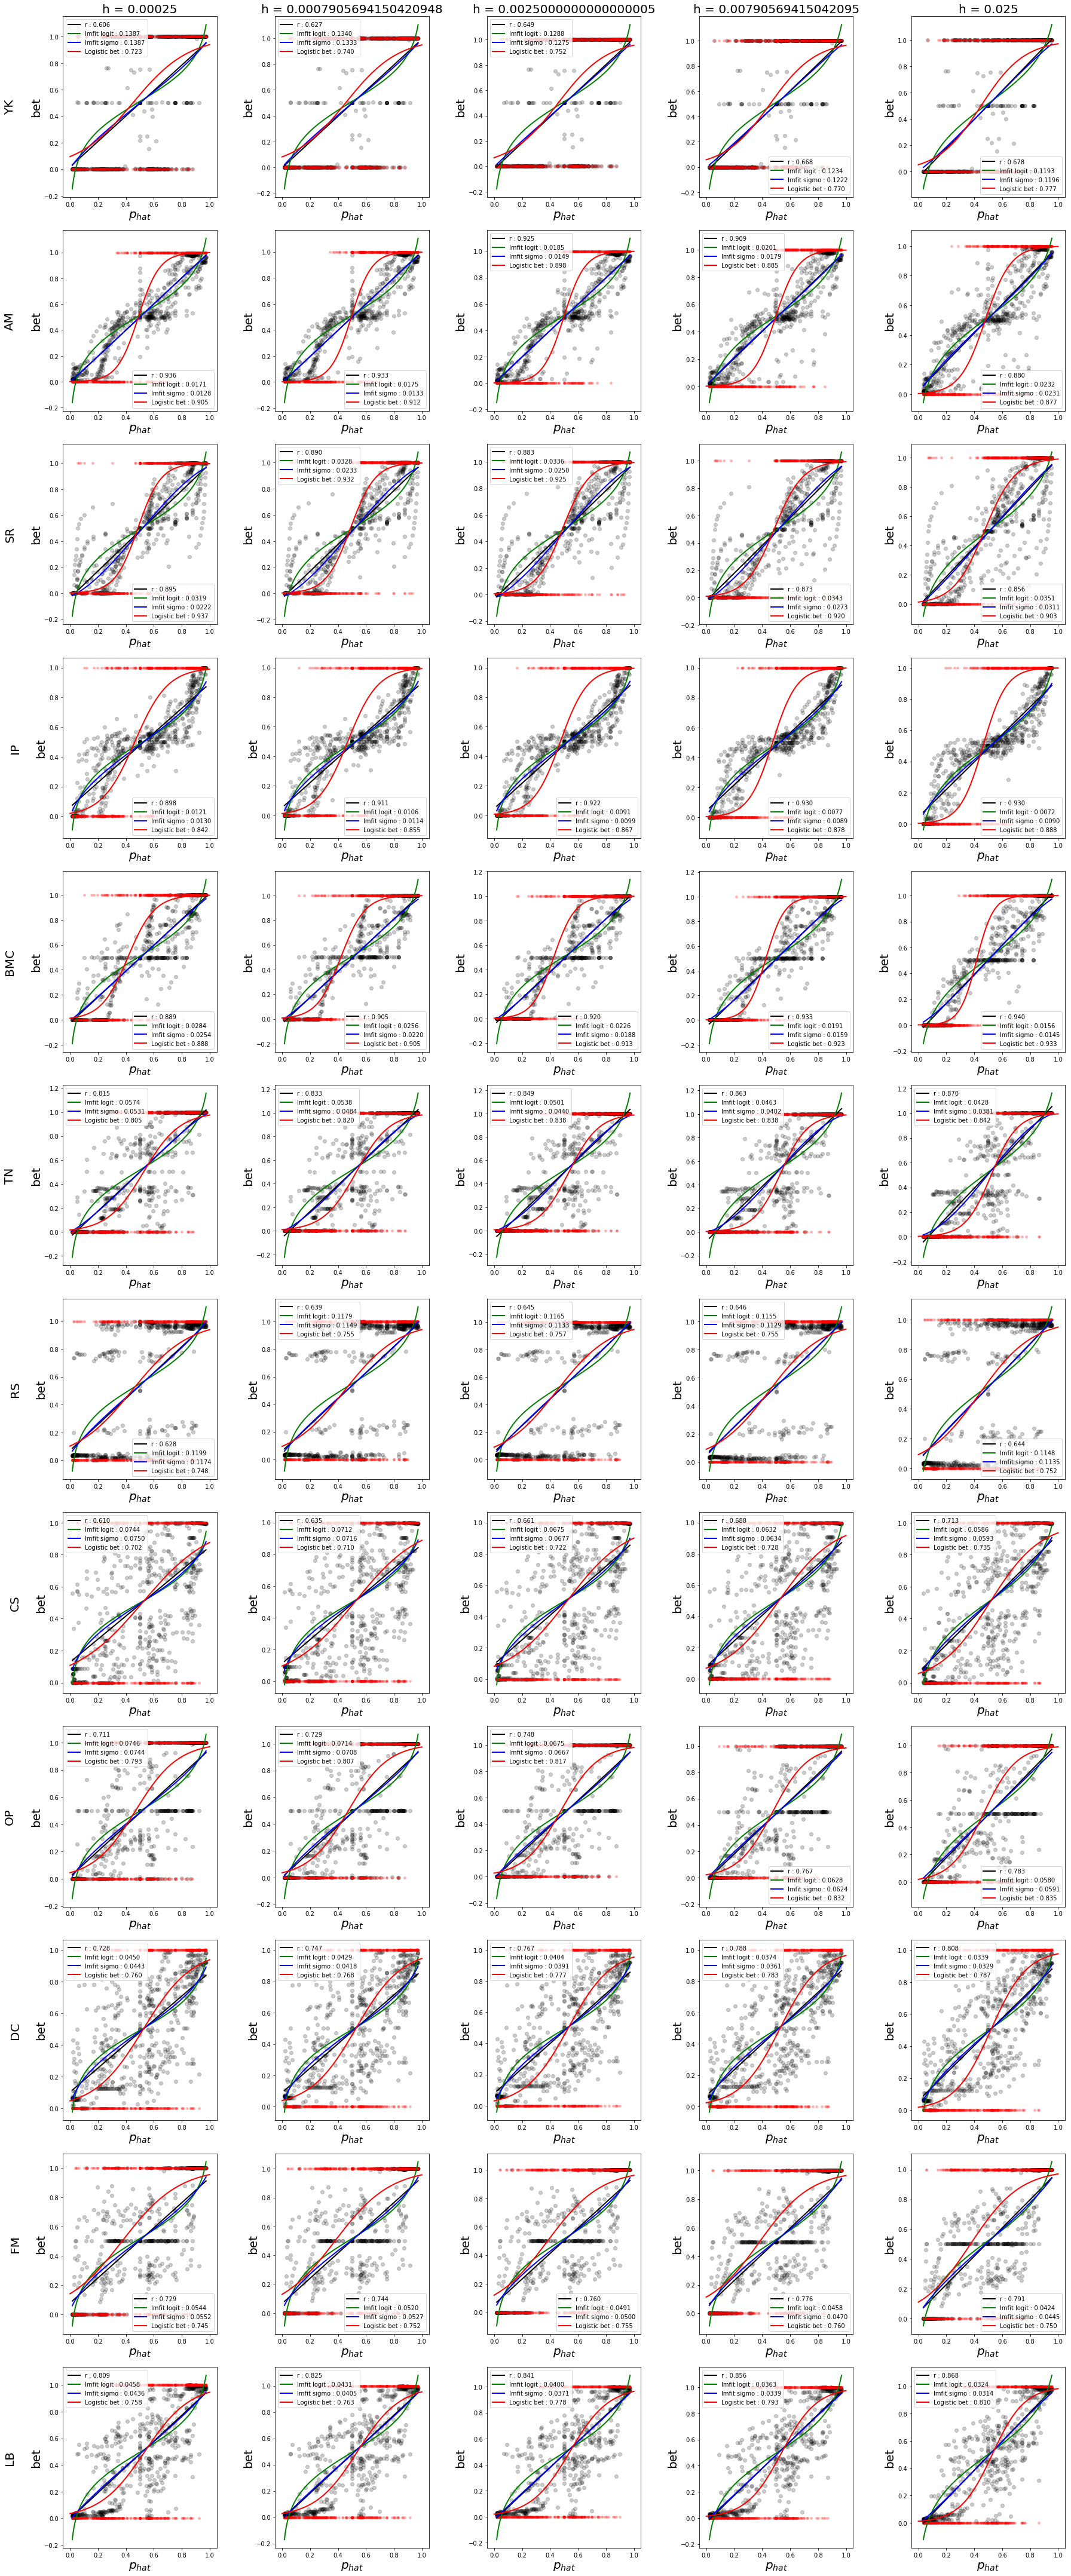

In [7]:
P_hat_vs_P_bet(nb_trial=600, pause=True)

YK AM SR IP BMC TN RS CS OP DC FM LB 

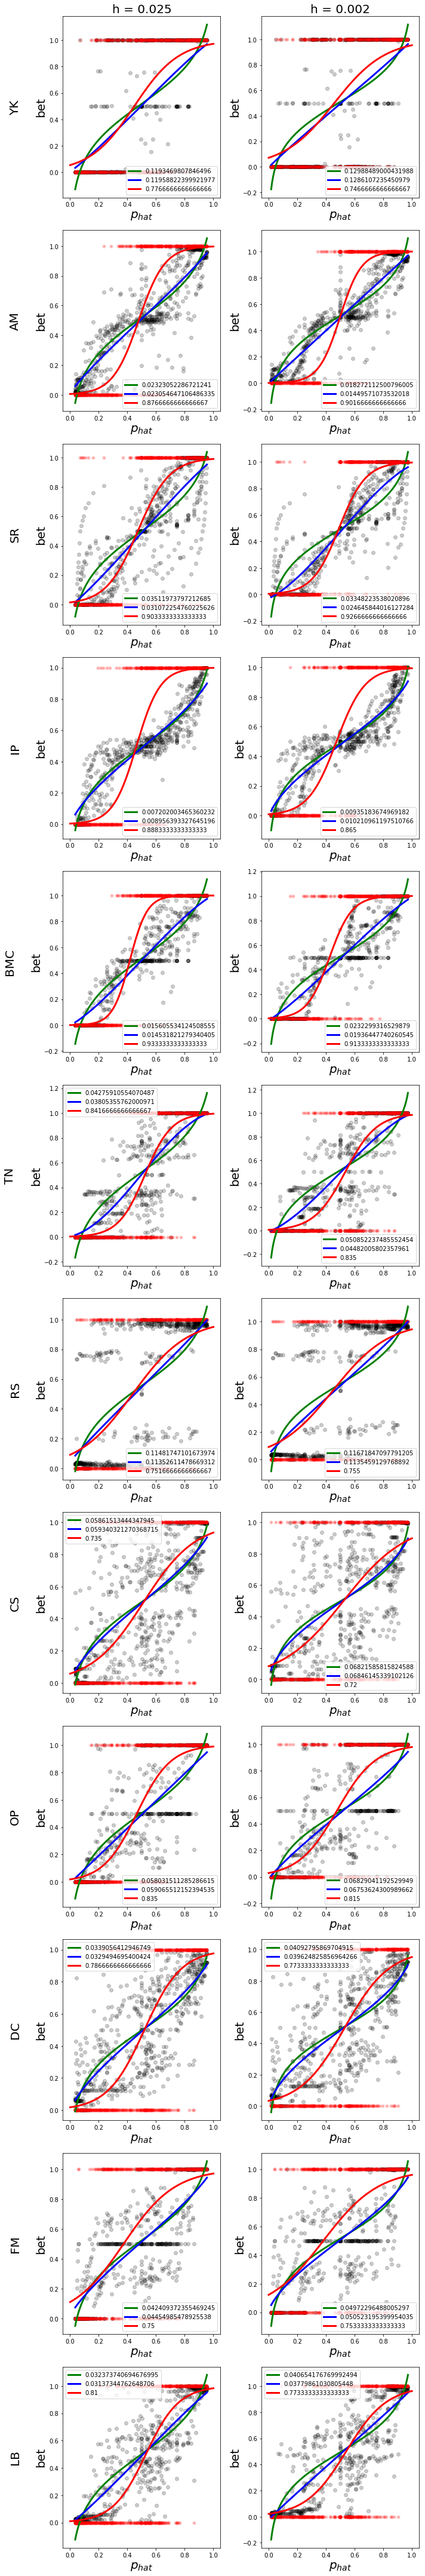

In [8]:
from sklearn import linear_model
from scipy.special import expit
from lmfit import Model

Full = e.Full_list(modes_bcp=[])
list_h= [1/40, 1/500] #1/40 * np.logspace(-2, 0., 5)
SUJETS = list(set(Full.sujet)) #['AM', 'LB']#, 'SR', 'LB']

fig, ax = plt.subplots(len(SUJETS),len(list_h),figsize=(len(list_h)*5,len(SUJETS)*5))


from scipy.optimize import curve_fit
'''def sigmoid(a, k, y):
    return 1 / (1 + np.exp(a+(k*y)))'''

def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))

def func_l(x, k, a):
    return (a + k*logit(x))

def func_s(x, k, a):
    return (a + sigmoid(k*logit(x))) #sigmoid(a, k, x) #sigmoid(k*x)+z #sigmoid(k*logit(x))+z

modes_bcp = 'mean'

for n_s, s in enumerate(SUJETS):
    print(s, end=' ')

    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    for n_h, h in enumerate(list_h) :

            p_hat = np.zeros(600)
            liste = np.arange(0, 601, 50)
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(x[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                p_hat[liste[a]:liste[a+1]] = p_hat_p
            ax[n_s][n_h].scatter(p_hat, bet, c='k', alpha=0.2)
            ax[n_s][n_h].set_xlabel('$p_{hat}$', fontsize=20)
            ax[n_s][n_h].set_ylabel('bet', fontsize=20)
            if n_s==0: ax[n_s][n_h].set_title('h = %s'%h, fontsize=20)
            if n_h==0: ax[n_s][n_h].set_ylabel('%s\n\nbet'%(s), fontsize=20)

            
            X_test = np.linspace(0, 1, 100)
            phat_sort = np.array(sorted(p_hat))
            bet_sort = [bet[x] for x in np.argsort(p_hat)]
            
            gmodel = Model(func_l)
            result = gmodel.fit(bet_sort, x=phat_sort, k=1, a=0, nan_policy='omit')
            ax[n_s][n_h].plot(phat_sort, result.best_fit, 'g', linewidth=3,
                              label='%s'%(result.redchi))
            
            gmodel = Model(func_s)
            result = gmodel.fit(bet_sort, x=phat_sort, k=1, a=0, nan_policy='omit')
            ax[n_s][n_h].plot(phat_sort, result.best_fit, 'b', linewidth=3,
                              label='%s'%(result.redchi))
            
            
            
            #-------------------------------------------------------------------
            X = phat_sort
            X = X[:, np.newaxis]
            y = [0 if bet_sort[x]<0.5 else 1 for x in range(len(bet_sort))]
            clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs').fit(X, y)

            

            loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
            ax[n_s][n_h].scatter(X, y, color='r', linewidth=3, s=10, alpha=0.2)
            ax[n_s][n_h].plot(X_test, loss, color='r', linewidth=3, label=clf.score(X, y))

            #-------------------------------------------------------------------
            '''popt, pcov = curve_fit(func_l, phat_sort, bet_sort)#, bounds=(0, [0.1, 0.6, 1.05]))
            std = np.sqrt(np.diag(pcov))
            ax[n_s][n_h].plot(phat_sort, func_l(phat_sort, *popt), c='g', linewidth=2,  ls='--',
                              label='fit_l: k=%s, %s'%(np.round(popt, 2), np.round(std, 2)))
            popt, pcov = curve_fit(func_s, phat_sort, bet_sort)#, bounds=(0, [0.1, 0.6, 1.05]))
            std = np.sqrt(np.diag(pcov))
            ax[n_s][n_h].plot(phat_sort, func_s(phat_sort, *popt), c='b', linewidth=2, ls='--',
                              label='fit_l: k=%s, %s'%(np.round(popt, 2), np.round(std, 2)))'''
            #popt, pcov = curve_fit(func_s, p_hat, bet)
            #ax[n_s][n_h].scatter(p_hat, func_s(p_hat, *popt), c='b', s=5, label='fit_s: k=%s, %s'%(np.round(popt, 2),
            #                                                                                       np.round(std, 2)))

            ax[n_s][n_h].legend()

plt.tight_layout()
